In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from typing import List, Optional


class Autoencoder(nn.Module):
    def __init__(
        self,
        input_dim: int = 128,
        hidden_dims: List[int] = [64, 32],
        latent_dim: int = 16,
        activation_type: str = "ReLU",
        output_activation_type: Optional[str] = None,
    ) -> None:
        super(Autoencoder, self).__init__()

        # Select activation function
        activation: nn.Module
        if activation_type == "ReLU":
            activation = nn.ReLU()
        elif activation_type == "LeakyReLU":
            activation = nn.LeakyReLU()
        elif activation_type == "ELU":
            activation = nn.ELU()
        else:
            raise ValueError("Unknown activation type provided")

        # Build encoder
        encoder_layers: List[nn.Module] = []
        current_dim: int = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(current_dim, h_dim))
            encoder_layers.append(activation)
            current_dim = h_dim

        # Latent layer
        encoder_layers.append(nn.Linear(current_dim, latent_dim))
        self.encoder: nn.Sequential = nn.Sequential(*encoder_layers)

        # Select output activation function
        output_activation: Optional[nn.Module] = None
        if output_activation_type == "ReLU":
            output_activation = nn.ReLU()
        elif output_activation_type == "LeakyReLU":
            output_activation = nn.LeakyReLU()
        elif output_activation_type == "ELU":
            output_activation = nn.ELU()
        elif output_activation_type == "Sigmoid":
            output_activation = nn.Sigmoid()
        elif output_activation_type == "Tanh":
            output_activation = nn.Tanh()
        elif output_activation_type is None:
            output_activation = None
        else:
            raise ValueError("Unknown activation type provided")

        # Build decoder
        decoder_layers: List[nn.Module] = []
        current_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(current_dim, h_dim))
            decoder_layers.append(activation)
            current_dim = h_dim

        # Add final output layer
        decoder_layers.append(nn.Linear(current_dim, input_dim))

        # Add output activation if specified
        if output_activation is not None:
            decoder_layers.append(output_activation)

        self.decoder: nn.Sequential = nn.Sequential(*decoder_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded: torch.Tensor = self.encoder(x)
        decoded: torch.Tensor = self.decoder(encoded)
        return decoded

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

Import Dataset

Train set

In [3]:
train_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/train_set.csv"
)
train_df = pd.read_csv(train_set_path)
# get only sample
train_df = train_df.sample(frac=0.1, random_state=42)
print(train_df.shape)
train_df.head()

(5387, 122)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
28282,-0.102571,-0.007723,-0.004728,-0.014089,-0.089487,-0.007736,1.765416,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
19433,-0.110250,-0.007666,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
30618,-0.110250,-0.007733,-0.004414,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
14731,-0.110250,-0.007674,-0.004918,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
26126,-0.110250,-0.007642,-0.004835,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432


Train autoencoder

In [4]:
# Model parameters
input_dim = train_df.shape[1]
hidden_dims = [input_dim, 100, 80]
latent_dim = 55

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(
    input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim
).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [5]:
# Prepare DataLoader for training autoencoder
tensor_x = torch.tensor(train_df.values, dtype=torch.float32)  # Specify dtype
train_dataset = TensorDataset(tensor_x)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [6]:
model.train()
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        # Extract tensor from tuple and move to device
        x = batch[0].to(device)  # Changed this line

        # Forward pass
        outputs = model(x)  # Use x instead of batch
        loss = criterion(outputs, x)  # Use x instead of batch

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print epoch statistics
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}")

Epoch [1/10], Average Loss: 0.485404
Epoch [2/10], Average Loss: 0.476556
Epoch [3/10], Average Loss: 0.470928
Epoch [4/10], Average Loss: 0.432838
Epoch [5/10], Average Loss: 0.454561
Epoch [6/10], Average Loss: 0.421984
Epoch [7/10], Average Loss: 0.401178
Epoch [8/10], Average Loss: 0.366915
Epoch [9/10], Average Loss: 0.362317
Epoch [10/10], Average Loss: 0.331567


In [7]:
# Export model to ONNX
dummy_input = torch.randn(
    1, input_dim, device=device
)  # Create dummy input with same dimensions as your data
output_path = "autoencoder_model.onnx"

# Export the model
torch.onnx.export(
    model,  # model being run
    dummy_input,  # model input (or a tuple for multiple inputs)
    output_path,  # where to save the model
    export_params=True,  # store the trained parameter weights inside the model file
    opset_version=11,  # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=["input"],  # the model's input names
    output_names=["output"],  # the model's output names
    dynamic_axes={
        "input": {0: "batch_size"},  # variable length axes
        "output": {0: "batch_size"},
    },
)

print(f"Model exported to {output_path}")

Model exported to autoencoder_model.onnx


In [8]:
# Get latent representations for training data
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Convert training data to tensor and move to device
    train_tensor = torch.tensor(train_df.values, dtype=torch.float32).to(device)
    # Get latent representations
    train_latent = model.encode(train_tensor).cpu().numpy()

Test set

In [9]:
test_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/test_set.csv"
)
test_df = pd.read_csv(test_set_path)
test_df = test_df.sample(frac=0.1, random_state=42)
print(test_df.shape)
test_df.head()

(2254, 125)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
6186,2.714844,-0.007762,-0.004908,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,-1,processtable,DoS
247,-0.110250,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,1.616969,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,neptune,DoS
4343,-0.110250,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,mscan,Probe
16283,-0.110250,-0.007733,0.000878,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,1,normal,normal
15889,-0.110250,-0.007744,-0.004882,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,-1,snmpgetattack,R2L


In [10]:
X_test = test_df.drop(columns=["attack_binary", "attack_categorical", "attack_class"])
y_true = test_df["attack_binary"]

In [11]:
X_test.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
6186,2.714844,-0.007762,-0.004908,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.312890,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
247,-0.110250,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.312890,-0.11205,-0.028606,-0.139983,1.616969,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432
4343,-0.110250,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,3.196006,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432
16283,-0.110250,-0.007733,0.000878,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.312890,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
15889,-0.110250,-0.007744,-0.004882,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.312890,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432


In [12]:
y_true.head()

6186    -1
247     -1
4343    -1
16283    1
15889   -1
Name: attack_binary, dtype: int64

In [13]:
# Get latent representations for test data
with torch.no_grad():
    # Convert test data to tensor and move to device
    test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    # Get latent representations
    test_latent = model.encode(test_tensor).cpu().numpy()

In [14]:
# Initialize and train OCSVM
ocsvm = OneClassSVM(kernel="rbf", nu=0.14, gamma=1)
ocsvm.fit(train_latent)

OneClassSVM(gamma=1, nu=0.14)

In [15]:
# Predict on test set
y_pred = ocsvm.predict(test_latent)

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1306    0]
 [ 948    0]]


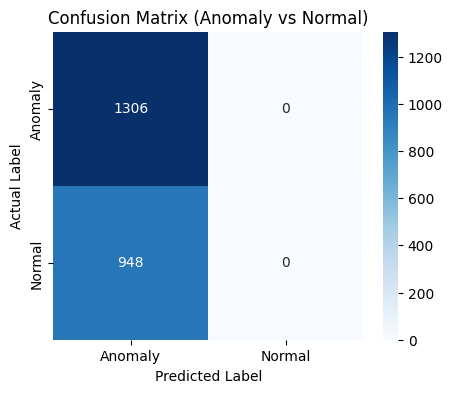

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [18]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Anomaly", "Normal"]))

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label=-1)
recall = recall_score(y_true, y_pred, pos_label=-1)
f1 = f1_score(y_true, y_pred, pos_label=-1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.58      1.00      0.73      1306
      Normal       0.00      0.00      0.00       948

    accuracy                           0.58      2254
   macro avg       0.29      0.50      0.37      2254
weighted avg       0.34      0.58      0.43      2254

Accuracy: 0.5794
Precision: 0.5794143744454303
Recall: 1.0
F1 Score: 0.7337078651685394


/home/jbct/Projects/thesis/db-ocsvm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jbct/Projects/thesis/db-ocsvm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jbct/Projects/thesis/db-ocsvm/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

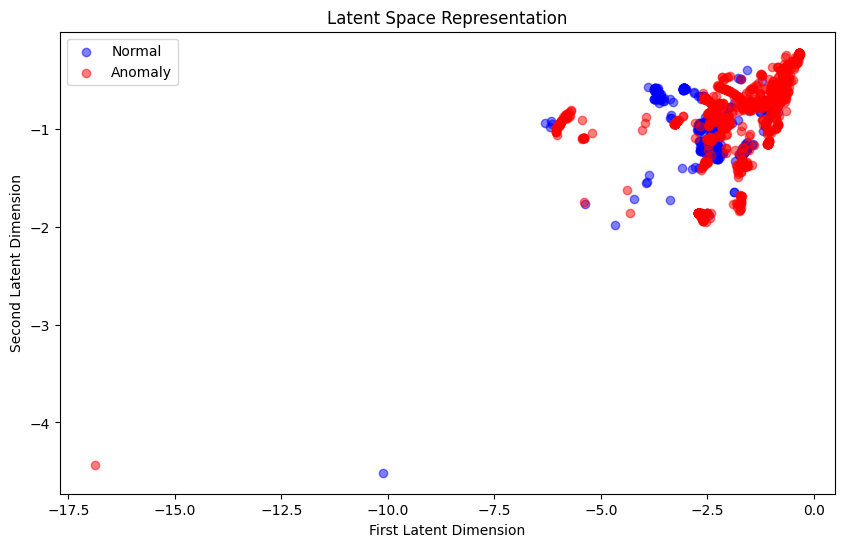

In [19]:
# Optional: Plot latent representations
plt.figure(figsize=(10, 6))
plt.scatter(
    test_latent[y_true == 1][:, 0],
    test_latent[y_true == 1][:, 1],
    c="blue",
    label="Normal",
    alpha=0.5,
)
plt.scatter(
    test_latent[y_true == -1][:, 0],
    test_latent[y_true == -1][:, 1],
    c="red",
    label="Anomaly",
    alpha=0.5,
)
plt.title("Latent Space Representation")
plt.xlabel("First Latent Dimension")
plt.ylabel("Second Latent Dimension")
plt.legend()
plt.show()